<a href="https://colab.research.google.com/github/felipeescallon/TensorFlow-TPU-vs-GPU/blob/main/Copia_de_GPU_vs_TPU_(GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Configuration
## 1.1 Define some constants 

In [1]:
GCS_PATH = 'gs://tf-everywhere-col'
DATASET_NAME = 'rock_paper_scissors'
BATCH_SIZE = 128
NUM_CLASSES = 3
DENSE_UNITS = 128
DROPOUT = 0.4

## 1.2 Validate GPU connection

In [2]:
!nvidia-smi

Fri Mar 19 00:32:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.3 Authenticate

In [3]:
from google.colab import auth

auth.authenticate_user()

## 1.4 Setup dependencies

In [4]:
!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers, callbacks
from datetime import datetime

     |████████████████████████████████| 706kB 7.6MB/s 


# 2. Dataset definition

In [5]:
train_ds, train_ds_info = tfds.load(DATASET_NAME, 
                                    split="train", 
                                    with_info=True, 
                                    shuffle_files=True,
                                    data_dir=f'{GCS_PATH}/{DATASET_NAME}/train')
val_ds, val_ds_info = tfds.load(DATASET_NAME, 
                                split="test",
                                with_info=True, 
                                shuffle_files=False, 
                                data_dir=f'{GCS_PATH}/{DATASET_NAME}/val')

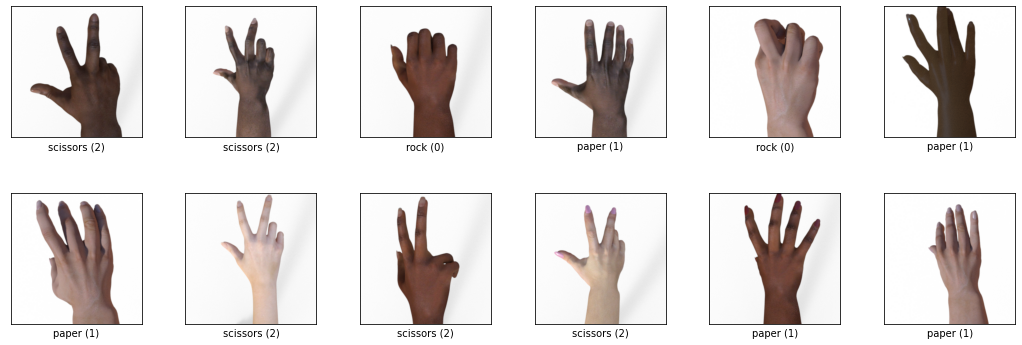

In [6]:
tfds.visualization.show_examples(train_ds, train_ds_info, rows=2, cols=6);

## 2.1 Data Preprocessing

In [7]:
from tensorflow.data.experimental import AUTOTUNE

@tf.function
def preprocess(example, height=224, width=224):
    image = example['image']
    label = example['label']
    image = tf.image.resize_with_crop_or_pad(image, height, width)
  
    image = tf.keras.applications.resnet.preprocess_input(image)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image,label

def get_datasets(train_ds, val_ds, batch_size):
    norm_train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)\
            .shuffle(500).batch(batch_size).prefetch(AUTOTUNE)
    norm_val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)\
            .batch(batch_size).cache()
    return norm_train_ds, norm_val_ds

## 2.3 Create train/val datasets

In [8]:
norm_train_ds, norm_val_ds = get_datasets(train_ds, val_ds, 
                batch_size=BATCH_SIZE)

# 3. Model definition

In [9]:
def create_model(num_classes, units, dropout):

  input_layer = layers.Input(shape=(224,224,3))

  feature_extractor = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)
  feature_extractor.trainable = False

  features = layers.GlobalAveragePooling2D()(feature_extractor.output)
  x = layers.Dense(units, 'relu')(features)
  x = layers.Dropout(dropout)(x)
  x = layers.Dense(num_classes, 'softmax', dtype='float32')(x)

  model = Model(inputs=[input_layer], outputs=[x], name='feature_extractor')
  model.summary()
  return model

## 3.1 Create & Compile

Create and compile as usual

In [10]:
model = create_model(NUM_CLASSES, DENSE_UNITS, DROPOUT)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')])

94773248/94765736 [==============================] - 1s 0us/step
Model: "feature_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________

## 3.2 Train & Validate model

In [11]:
%%time
history = model.fit(norm_train_ds, validation_data=norm_val_ds, epochs=20)

Epoch 1/20
20/20 [==============================] - 52s 786ms/step - loss: 1.5593 - categorical_accuracy: 0.5534 - f1_score: 0.5475 - val_loss: 0.8526 - val_categorical_accuracy: 0.7366 - val_f1_score: 0.7232
Epoch 2/20
20/20 [==============================] - 12s 504ms/step - loss: 0.6191 - categorical_accuracy: 0.9577 - f1_score: 0.9581 - val_loss: 0.8536 - val_categorical_accuracy: 0.7097 - val_f1_score: 0.6894
Epoch 3/20
20/20 [==============================] - 12s 510ms/step - loss: 0.5671 - categorical_accuracy: 0.9872 - f1_score: 0.9872 - val_loss: 0.8952 - val_categorical_accuracy: 0.6586 - val_f1_score: 0.6226
Epoch 4/20
20/20 [==============================] - 12s 508ms/step - loss: 0.5534 - categorical_accuracy: 0.9895 - f1_score: 0.9899 - val_loss: 0.8052 - val_categorical_accuracy: 0.7016 - val_f1_score: 0.6744
Epoch 5/20
20/20 [==============================] - 12s 515ms/step - loss: 0.5446 - categorical_accuracy: 0.9960 - f1_score: 0.9961 - val_loss: 0.8431 - val_categor